In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import cv2

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

#import optimizer
from tensorflow.keras.optimizers import Adam

from skimage.transform import resize

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow 

import pandas as pd
import keras
import random
import math
import seaborn as sns
import nibabel as nib
import numpy as np
import skimage.transform as skTrans

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

#from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data=[]
imagePaths = sorted(list(os.listdir("studies/data/"))) # directory to dataset
print(imagePaths)
for img in imagePaths:
    path=sorted(list(os.listdir("studies/data/"+img)))
    count = 0
    #read the images
    for i in path:
        img_path = "studies/data/"+str(img)+'/'+str(i)
        image = nib.load(img_path) 
        image_d = image.get_fdata()
        queue = image.dataobj.shape[2]
        img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True) #resize the images size
        # if the case does not belong to "CT-1" class
        # it takes more scans of the lung
        if img !='CT-1': 
            img_arrs1 = img_arr[:,:,queue//4]
            img_arrs2 = img_arr[:,:,3*queue//4]
            img_arrs1 = resize(img_arrs1, output_shape = (128, 128, 3), preserve_range=True)
            img_arrs2 = resize(img_arrs2, output_shape = (128, 128, 3), preserve_range=True)
            data.append((img_arrs1, int(img[-1])))
            data.append((img_arrs2, int(img[-1])))
        img_arrs = img_arr[:,:,queue//2]
        img_arrs = resize(img_arrs, output_shape = (128, 128, 3), preserve_range=True)
        data.append((img_arrs, int(img[-1])))

['CT-0', 'CT-1', 'CT-2', 'CT-3', 'CT-4']


In [3]:
random.seed(0)
random.shuffle(data) #shuffle the images
image_data = []
classes = []
for d in data:
    image_data.append(d[0])
    classes.append(d[1])
image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)

In [4]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(1557, 128, 128, 3) (390, 128, 128, 3)


In [5]:
# import the model architecture
from tensorflow.keras.applications import ResNet50

# import layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate

# creating the base of the Model - ResNet50
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(256,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
preds = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

#To avoid the problem of overfitting, avoid training the entire network.
for layer in model.layers[:-16]:
    layer.trainable=False #will freeze all the layers except last 16 layers
    
for layer in model.layers[-16:]:
    layer.trainable=True # Once the model is fitted well, it can be fine-tuned
    
#compile the model with Adam optimizer    
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [58]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=30,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

(1362, 128, 128, 3) (585, 128, 128, 3)
Epoch 1/30
10/10 - 9s - loss: 0.0742 - accuracy: 0.9806 - val_loss: 0.0900 - val_accuracy: 0.9684

Epoch 00001: val_loss improved from inf to 0.09001, saving model to model.h5
Epoch 2/30
10/10 - 9s - loss: 0.0470 - accuracy: 0.9846 - val_loss: 0.0958 - val_accuracy: 0.9677

Epoch 00002: val_loss did not improve from 0.09001
Epoch 3/30
10/10 - 9s - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.0682 - val_accuracy: 0.9787

Epoch 00003: val_loss improved from 0.09001 to 0.06818, saving model to model.h5
Epoch 4/30
10/10 - 9s - loss: 0.0393 - accuracy: 0.9895 - val_loss: 0.0449 - val_accuracy: 0.9831

Epoch 00004: val_loss improved from 0.06818 to 0.04489, saving model to model.h5
Epoch 5/30
10/10 - 9s - loss: 0.0449 - accuracy: 0.9854 - val_loss: 0.0589 - val_accuracy: 0.9787

Epoch 00005: val_loss did not improve from 0.04489
Epoch 6/30
10/10 - 10s - loss: 0.0483 - accuracy: 0.9838 - val_loss: 0.0668 - val_accuracy: 0.9772

Epoch 00006: val_loss did

In [34]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 585 	accurately-predicted-data: 393 	 wrongly-predicted-data:  192
Accuracy: 67.179 %


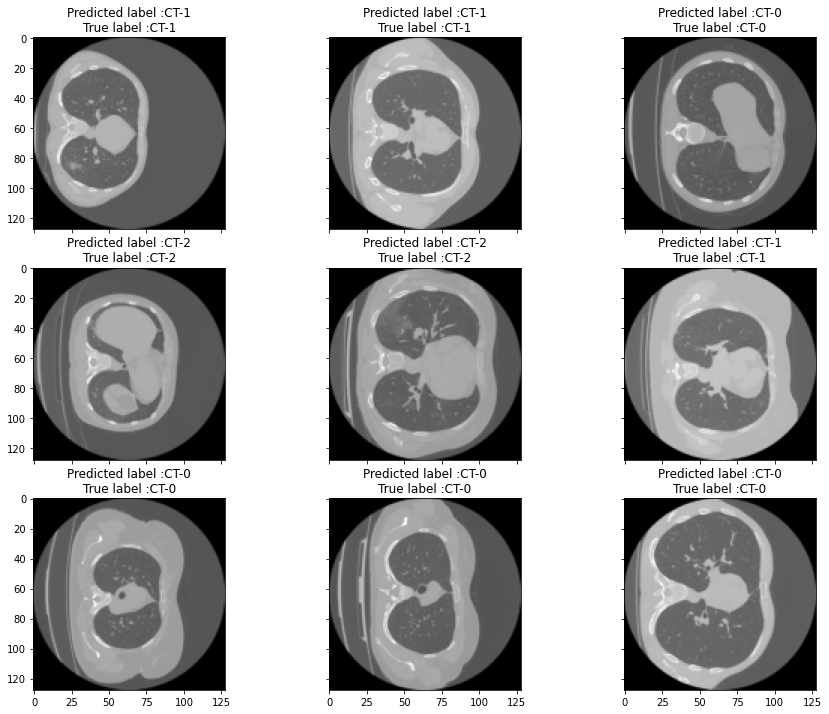

In [64]:
label= ['CT-0', 'CT-1', 'CT-2', 'CT-3']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))
k=0
n = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(xtest[imidx[n]][:,:,0], cmap='gray')
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
        n += 1

plt.show()

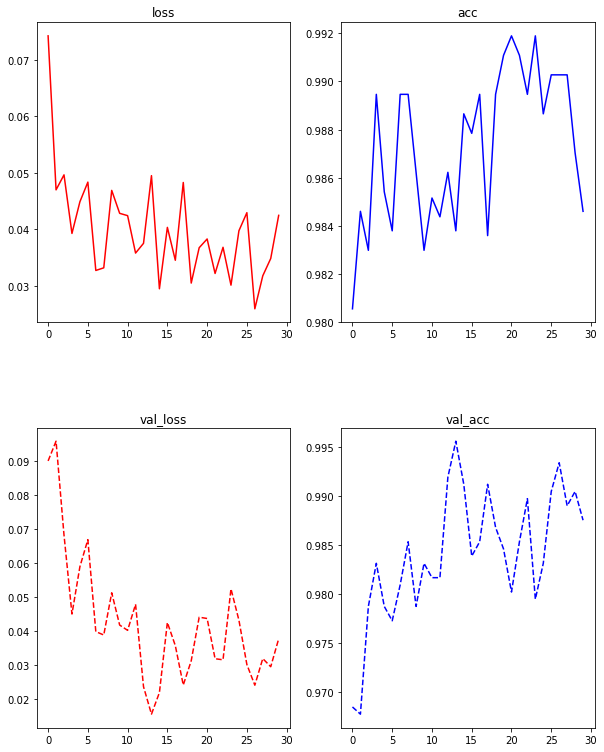

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')

In [66]:
class_names = ['CT-0', 'CT-1', 'CT-2', 'CT-3', 'CT-4']
y_pred_labels =[]
y_true_labels = []
for i in range(len(ypred)):
    y_pred_labels.append(class_names[np.argmax(ypred[i])])
    y_true_labels.append(class_names[np.argmax(ytest[i])])

Confusion matrix
[[175  32  13   2   1]
 [ 30 161  14   0   0]
 [ 44  26  45   1   0]
 [ 14   7   6  12   0]
 [  2   0   0   0   0]]


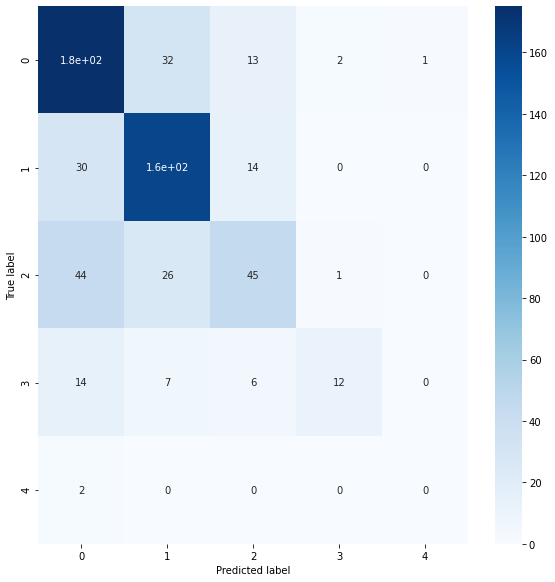

In [36]:
from sklearn.metrics import plot_confusion_matrix
disp = confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels,
                                 labels=class_names,
                                 normalize=None)


print("Confusion matrix")
print(disp)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(disp, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()